In [1]:
# Computations
import numpy as np
import pandas as pd

# sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex

## seaborn
import seaborn as sns
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("white")

## matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## missingno
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/IMDB_Logo_2016.svg/1280px-IMDB_Logo_2016.svg.png' width ='300' align="center"/>

<div class="alert alert-block alert-success">
<font size="+2"><b>IMDB Movie Dataset</b></font>
</div>

# Preprocessing

In this article, we use an IMDB movie dataset from Kaggle.com. The object of the exercise is to recommend similar movies to a given movie.

#### Loading the Data

In [2]:
Data = pd.read_csv('movie_metadata/movie_metadata.csv')
# column names
Data.columns = [x.title().replace('Imdb', 'IMDB') for x in Data.columns.tolist()]
Data.head().style.hide_index()

Color,Director_Name,Num_Critic_For_Reviews,Duration,Director_Facebook_Likes,Actor_3_Facebook_Likes,Actor_2_Name,Actor_1_Facebook_Likes,Gross,Genres,Actor_1_Name,Movie_Title,Num_Voted_Users,Cast_Total_Facebook_Likes,Actor_3_Name,Facenumber_In_Poster,Plot_Keywords,Movie_IMDB_Link,Num_User_For_Reviews,Language,Country,Content_Rating,Budget,Title_Year,Actor_2_Facebook_Likes,IMDB_Score,Aspect_Ratio,Movie_Facebook_Likes
Color,James Cameron,723.000000,178.000000,0.000000,855.000000,Joel David Moore,1000.000000,760505847.000000,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.000000,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054.000000,English,USA,PG-13,237000000.000000,2009.000000,936.000000,7.900000,1.780000,33000
Color,Gore Verbinski,302.000000,169.000000,563.000000,1000.000000,Orlando Bloom,40000.000000,309404152.000000,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.000000,goddess|marriage ceremony|marriage proposal|pirate|singapore,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,1238.000000,English,USA,PG-13,300000000.000000,2007.000000,5000.000000,7.100000,2.350000,0
Color,Sam Mendes,602.000000,148.000000,0.000000,161.000000,Rory Kinnear,11000.000000,200074175.000000,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.000000,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1,994.000000,English,UK,PG-13,245000000.000000,2015.000000,393.000000,6.800000,2.350000,85000
Color,Christopher Nolan,813.000000,164.000000,22000.000000,23000.000000,Christian Bale,27000.000000,448130642.000000,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.000000,deception|imprisonment|lawlessness|police officer|terrorist plot,http://www.imdb.com/title/tt1345836/?ref_=fn_tt_tt_1,2701.000000,English,USA,PG-13,250000000.000000,2012.000000,23000.000000,8.500000,2.350000,164000
nan,Doug Walker,nan,nan,131.000000,nan,Rob Walker,131.000000,nan,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens,8,143,nan,0.000000,nan,http://www.imdb.com/title/tt5289954/?ref_=fn_tt_tt_1,nan,nan,nan,nan,nan,nan,12.000000,7.100000,nan,0


Sorting the dataset

In [3]:
Temp = sorted(Data.columns)
Temp.remove('Movie_Title')
Temp.insert(0, 'Movie_Title')
Data = Data.reindex(columns= Temp)
del Temp
Data.head().style.hide_index()

Movie_Title,Actor_1_Facebook_Likes,Actor_1_Name,Actor_2_Facebook_Likes,Actor_2_Name,Actor_3_Facebook_Likes,Actor_3_Name,Aspect_Ratio,Budget,Cast_Total_Facebook_Likes,Color,Content_Rating,Country,Director_Facebook_Likes,Director_Name,Duration,Facenumber_In_Poster,Genres,Gross,IMDB_Score,Language,Movie_Facebook_Likes,Movie_IMDB_Link,Num_Critic_For_Reviews,Num_User_For_Reviews,Num_Voted_Users,Plot_Keywords,Title_Year
Avatar,1000.000000,CCH Pounder,936.000000,Joel David Moore,855.000000,Wes Studi,1.780000,237000000.000000,4834,Color,PG-13,USA,0.000000,James Cameron,178.000000,0.000000,Action|Adventure|Fantasy|Sci-Fi,760505847.000000,7.900000,English,33000,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,723.000000,3054.000000,886204,avatar|future|marine|native|paraplegic,2009.000000
Pirates of the Caribbean: At World's End,40000.000000,Johnny Depp,5000.000000,Orlando Bloom,1000.000000,Jack Davenport,2.350000,300000000.000000,48350,Color,PG-13,USA,563.000000,Gore Verbinski,169.000000,0.000000,Action|Adventure|Fantasy,309404152.000000,7.100000,English,0,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,302.000000,1238.000000,471220,goddess|marriage ceremony|marriage proposal|pirate|singapore,2007.000000
Spectre,11000.000000,Christoph Waltz,393.000000,Rory Kinnear,161.000000,Stephanie Sigman,2.350000,245000000.000000,11700,Color,PG-13,UK,0.000000,Sam Mendes,148.000000,1.000000,Action|Adventure|Thriller,200074175.000000,6.800000,English,85000,http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1,602.000000,994.000000,275868,bomb|espionage|sequel|spy|terrorist,2015.000000
The Dark Knight Rises,27000.000000,Tom Hardy,23000.000000,Christian Bale,23000.000000,Joseph Gordon-Levitt,2.350000,250000000.000000,106759,Color,PG-13,USA,22000.000000,Christopher Nolan,164.000000,0.000000,Action|Thriller,448130642.000000,8.500000,English,164000,http://www.imdb.com/title/tt1345836/?ref_=fn_tt_tt_1,813.000000,2701.000000,1144337,deception|imprisonment|lawlessness|police officer|terrorist plot,2012.000000
Star Wars: Episode VII - The Force Awakens,131.000000,Doug Walker,12.000000,Rob Walker,nan,nan,nan,nan,143,nan,nan,nan,131.000000,Doug Walker,nan,0.000000,Documentary,nan,7.100000,nan,0,http://www.imdb.com/title/tt5289954/?ref_=fn_tt_tt_1,nan,nan,8,nan,nan


## Removing unnessary columns

Note that

In [4]:
print(Back.BLACK + Fore.CYAN + Style.NORMAL + 'Columns:'+ Style.RESET_ALL + ' %s' % ', '.join(Data.columns))

Columns: Movie_Title, Actor_1_Facebook_Likes, Actor_1_Name, Actor_2_Facebook_Likes, Actor_2_Name, Actor_3_Facebook_Likes, Actor_3_Name, Aspect_Ratio, Budget, Cast_Total_Facebook_Likes, Color, Content_Rating, Country, Director_Facebook_Likes, Director_Name, Duration, Facenumber_In_Poster, Genres, Gross, IMDB_Score, Language, Movie_Facebook_Likes, Movie_IMDB_Link, Num_Critic_For_Reviews, Num_User_For_Reviews, Num_Voted_Users, Plot_Keywords, Title_Year


The following three columns are unnecessary for our study. Thus, we are going to remove these columns.
* `Facenumber_In_Poster`
* `Movie_IMDB_Link`
* `Aspect_Ratioo`

In [5]:
Drop_column_list = ['Facenumber_In_Poster', 'Movie_IMDB_Link', 'Aspect_Ratio']
display(Data[Drop_column_list].head())

,Facenumber_In_Poster,Movie_IMDB_Link,Aspect_Ratio
0,0.0,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,1.78
1,0.0,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,2.35
2,1.0,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,2.35
3,0.0,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2.35
4,0.0,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN


Thus, these columns are dropped from our data

In [6]:
Data.drop(Drop_column_list, axis=1, inplace=True)
del Drop_column_list

## Duplicated Values

First off, note that

In [7]:
Data_Duplicated = Data[Data.Movie_Title.duplicated(keep='last')]
pd.DataFrame(Data_Duplicated.Movie_Title)

,Movie_Title
6,Spider-Man 3
17,The Avengers
25,King Kong
30,Skyfall
33,Alice in Wonderland
...,...
3800,Saving Grace
3887,Night of the Living Dead
3984,The Full Monty
4223,The Calling


These values are duplicated!

In [8]:
print("There are %i unique rows from %i."% (len(Data.Movie_Title.unique()), len(Data.Movie_Title)))
number_of_duplicated=len(Data.Movie_Title)-len(Data.Movie_Title.unique())
print("There are %i duplicated rows."% number_of_duplicated)
del number_of_duplicated, Data_Duplicated

There are 4917 unique rows from 5043.
There are 126 duplicated rows.


Removing the duplicated movies.

In [9]:
Data.drop_duplicates(subset="Movie_Title", inplace=True)

## Missing values

In [10]:
def Data_info(Inp, Only_NaN = False):
    Out = Inp.dtypes.to_frame(name='Data Type').sort_values(by=['Data Type'])
    Out = Out.join(Inp.isnull().sum().to_frame(name = 'Number of NaN Values'), how='outer')
    Out ['Size'] = Inp.shape[0]
    Out['Percentage'] = np.round(100*(Out['Number of NaN Values']/Inp.shape[0]),2)
    if Only_NaN:
        Out = Out.loc[Out['Number of NaN Values']>0]
    return Out
Temp = Data_info(Data)
display(Temp)

,Data Type,Number of NaN Values,Size,Percentage
Actor_1_Facebook_Likes,float64,7,4917,0.14
Actor_1_Name,object,7,4917,0.14
Actor_2_Facebook_Likes,float64,13,4917,0.26
Actor_2_Name,object,13,4917,0.26
Actor_3_Facebook_Likes,float64,23,4917,0.47
Actor_3_Name,object,23,4917,0.47
Budget,float64,484,4917,9.84
Cast_Total_Facebook_Likes,int64,0,4917,0.00
Color,object,19,4917,0.39
Content_Rating,object,300,4917,6.10


```msno.bar``` is a simple visualization of nullity by column (see [this link](https://github.com/ResidentMario/missingno) for more details):

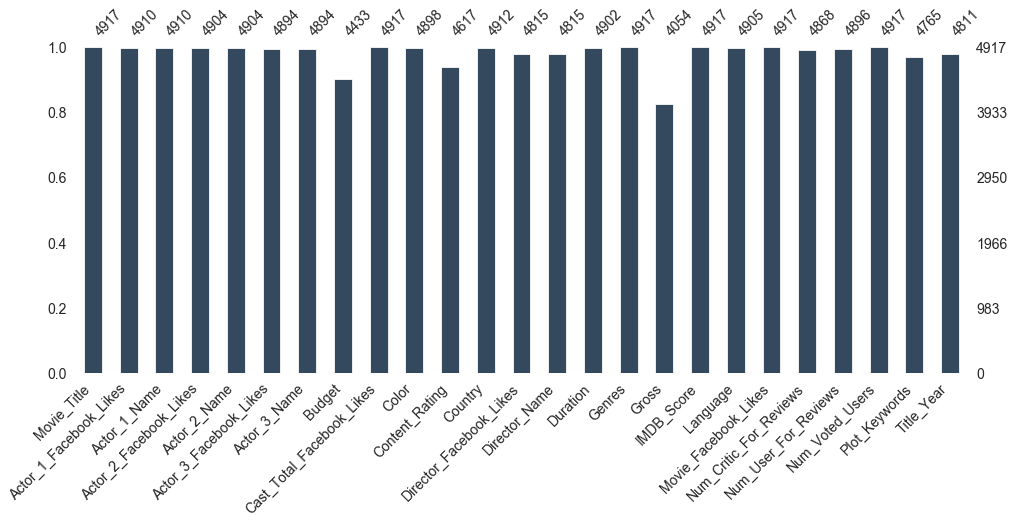

In [11]:
_ = msno.bar(Data, figsize=(16,6), fontsize=14, log=False, color="#34495e")

In [12]:
Temp = Temp.loc[ Temp['Number of NaN Values']>0].index.tolist()
print(Back.BLACK + Fore.RED + Style.NORMAL + 'Columns with NaN values:'+ Style.RESET_ALL + ' %s:' % ', '.join(Temp))

Columns with NaN values: Actor_1_Facebook_Likes, Actor_1_Name, Actor_2_Facebook_Likes, Actor_2_Name, Actor_3_Facebook_Likes, Actor_3_Name, Budget, Color, Content_Rating, Country, Director_Facebook_Likes, Director_Name, Duration, Gross, Language, Num_Critic_For_Reviews, Num_User_For_Reviews, Plot_Keywords, Title_Year:


<div class="alert alert-danger" role="alert">
<font size="+1"><b>Column: Director_Name</b></font>
</div>

We can just simply drop rows without `director_name`.

In [13]:
Data.drop(Data[Data.Director_Name.isna()].index, inplace=True)

<div class="alert alert-danger" role="alert">
<font size="+1"><b>Column: Budget</b></font>
</div>

We can just simply drop rows without `director_name`.

We can use [**sklearn.impute.SimpleImputer**](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) for imputation transformer for completing missing values.

In [14]:
imp= SimpleImputer(missing_values=np.nan, strategy='mean')
temp=imp.fit_transform(Data['Budget'].values.reshape(-1, 1))
Data['Budget']=temp
del temp, imp

<div class="alert alert-danger" role="alert">
<font size="+1"><b>Column: Color</b></font>
</div>

For moviess `color`, we have

In [15]:
Ind = Data.Color.isna()
Data.loc[Ind, ['Movie_Title','Title_Year','Color']].sort_values(by='Title_Year', ascending=True).head()

,Movie_Title,Title_Year,Color
4846,Midnight Cabaret,1990.0,NaN
2753,Shinjuku Incident,2009.0,NaN
1948,Dear John,2010.0,NaN
3638,Snow Flower and the Secret Fan,2011.0,NaN
5020,The Ridges,2011.0,NaN


We can assume that these movies are all in color since the earliest movie on this list is 1990. Thus,

In [16]:
Data.Color.fillna('Color', inplace=True)
display(Data.loc[Ind, ['Movie_Title','Title_Year','Color']].sort_values(by='Title_Year', ascending=True).head())

,Movie_Title,Title_Year,Color
4846,Midnight Cabaret,1990.0,Color
2753,Shinjuku Incident,2009.0,Color
1948,Dear John,2010.0,Color
3638,Snow Flower and the Secret Fan,2011.0,Color
5020,The Ridges,2011.0,Color


<div class="alert alert-danger" role="alert">
<font size="+1"><b>Column: Language</b></font>
</div>

As for the `Language`, we have,

In [17]:
Temp = [str(x) for x in Data.Language.unique()]
print(Back.YELLOW + Fore.BLACK + Style.NORMAL + 'Languages:'+ Style.RESET_ALL + ' %s:' % ', '.join(Temp))

Languages: English, nan, Japanese, French, Mandarin, Aboriginal, Spanish, Filipino, Hindi, Russian, Maya, Kazakh, Telugu, Cantonese, German, Aramaic, Italian, Dutch, Dari, Hebrew, Chinese, Mongolian, Swedish, Korean, Thai, Bosnian, None, Hungarian, Portuguese, Icelandic, Danish, Arabic, Norwegian, Czech, Kannada, Zulu, Panjabi, Polish, Tamil, Dzongkha, Vietnamese, Indonesian, Urdu, Romanian, Persian, Slovenian, Greek, Swahili:


We can see undesired values such as *NaN* and *None*. First, let's deal with *None*. We have

In [18]:
Data.loc[Data.Language == 'None', 'Country']

2895    Canada
3931       USA
Name: Country, dtype: object

We can assume that these movies have been produced in English.

In [19]:
Data.loc[Data.Language.isna(), 'Country']

4       NaN
279     NaN
3086    USA
3539    USA
3869    USA
4110    USA
4409    USA
4630    USA
4810    USA
4885    USA
4958    USA
Name: Country, dtype: object

Since most movies are from the USA, we can assume that these movies have been produced in English. Therefore,

In [20]:
Data.Language.fillna('English', inplace=True)
Data.Language.replace('None', 'English', inplace=True)

<div class="alert alert-danger" role="alert">
<font size="+1"><b>Column: Duration</b></font>
</div>

We can see that `Duration` of some movies are missing.

In [21]:
Data.loc[Data.Duration.isna(), ['Movie_Title','Duration']].head()

,Movie_Title,Duration
4,Star Wars: Episode VII - The Force Awakens ...,NaN
199,Harry Potter and the Deathly Hallows: Part II,NaN
206,Harry Potter and the Deathly Hallows: Part I,NaN
1510,Black Water Transit,NaN
3815,Should've Been Romeo,NaN


There is nothing that can be done regarding these movies and we are going to simply drop them.

In [22]:
Data.drop(Data.loc[Data.Duration.isna()].index, inplace=True)
display(Data.loc[Data.Title_Year.isna(), ['Movie_Title','Title_Year']])

,Movie_Title,Title_Year
279,"10,000 B.C.",NaN
2765,Towering Inferno,NaN
2870,Del 1 - Män som hatar kvinnor,NaN


Drop these data as well.

In [23]:
Data.drop(Data.loc[Data.Title_Year.isna()].index, inplace=True)

<div class="alert alert-danger" role="alert">
<font size="+1"><b>Column: Country</b></font>
</div>

As for `Country`, there is only one movie with the country name.

In [24]:
temp=Data.loc[Data.Country.isna(),('Movie_Title','Actor_1_Name','Actor_2_Name','Actor_3_Name','Director_Name','Country')]
temp

,Movie_Title,Actor_1_Name,Actor_2_Name,Actor_3_Name,Director_Name,Country
4021,Dawn Patrol,Chris Brochu,Jeff Fahey,Rita Wilson,Daniel Petrie Jr.,NaN


We can search the data for the actor's names and their other movies.

In [25]:
Data.loc[(Data.Actor_1_Name == temp.Actor_1_Name.values[0])|
         (Data.Actor_2_Name == temp.Actor_2_Name.values[0])|
         (Data.Actor_3_Name == temp.Actor_3_Name.values[0]),'Country']
del temp

This movie is made in the USA and we can replace *NaN* with the USA.

In [26]:
Data.Country.fillna('USA', inplace=True)

<div class="alert alert-danger" role="alert">
<font size="+1"><b>Column: Content_Rating</b></font>
</div>

For movie `ratings`, note that the ratings used since 1996 are [source](https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system)

| Rated | Description |
|-------|----------------------------------------------------------------------------------------|
| G | General audiences – All ages admitted. |
| PG | Parental guidance suggested – Some material may not be suitable for children. |
| PG-13 | Parents strongly cautioned – Some material may be inappropriate for children under 13. |
| R | Restricted – Under 17 requires accompanying parent or adult guardian. |
| NC-17 | No one 17 and under admitted. |

Thus, an standard list of ratings can be found as

In [27]:
Ratings_Standard = np.array(['G', 'PG', 'PG-13', 'R', 'NC-17'], dtype=object)
Ratings_Standard 

array(['G', 'PG', 'PG-13', 'R', 'NC-17'], dtype=object)

However,

In [28]:
Data.Content_Rating.unique()

array(['PG-13', 'PG', 'G', 'R', nan, 'TV-14', 'Not Rated', 'Unrated',
       'Approved', 'NC-17', 'X', 'GP', 'Passed', 'M', 'TV-G', 'TV-PG'],
      dtype=object)

We need to convert

In [29]:
list(set(Data.Content_Rating.unique().tolist())-set(Ratings_Standard))

[nan,
 'Unrated',
 'Passed',
 'GP',
 'TV-PG',
 'M',
 'X',
 'Approved',
 'Not Rated',
 'TV-G',
 'TV-14']

To the standard form. We can convert these values using the following table.

| Standard Format | Data Format |
|-----------------|--------------------|
| PG | G, TV-G, TV-PG, GP |
| R | M |
| Unrated | NaN,Not Rated |
| Approved | Passed |
| PG-13 | TV-14 |
| NC-17 | X |

In [30]:
Conversation_Map = {'PG':'PG', 'TV-G':'PG', 'GP':'PG','TV-PG':'PG',
                    'PG-13':'PG-13','TV-14':'PG-13',
                    'G':'PG', 'R':'R', 'M':'R',
                    np.nan:'Unrated', 'Unrated':'Unrated', 'Not Rated':'Unrated',
                    'Approved':'Approved', 'Passed':'Approved',
                    'NC-17':'NC-17', 'X':'NC-17'}

Data.content_rating = Data.Content_Rating.map(Conversation_Map)

display(Data.Content_Rating.unique())

array(['PG-13', 'PG', 'G', 'R', nan, 'TV-14', 'Not Rated', 'Unrated',
       'Approved', 'NC-17', 'X', 'GP', 'Passed', 'M', 'TV-G', 'TV-PG'],
      dtype=object)

<div class="alert alert-danger" role="alert">
<font size="+1"><b>Columns contain 'Actor'</b></font>
</div>

As for actors,

In [31]:
Columns=list(Data.columns)
# Actors Column List
Actors_Column_List=list()
for i in range(len(Columns)):
    if (Columns[i].find('Actor') != -1 & Columns[i].find('Likes') == -1):
        Actors_Column_List.append(Columns[i])
        
display(Data.loc[Data.Actor_1_Name.isna(), Actors_Column_List])

,Actor_1_Name,Actor_2_Name,Actor_3_Name
4502,NaN,NaN,NaN
4519,NaN,NaN,NaN
4720,NaN,NaN,NaN
4837,NaN,NaN,NaN
4945,NaN,NaN,NaN
4946,NaN,NaN,NaN
4990,NaN,NaN,NaN


Replacing these values with `'None'`.

In [32]:
Data.Actor_1_Name.fillna('None', inplace=True)
Data.Actor_2_Name.fillna('None', inplace=True)
Data.Actor_3_Name.fillna('None', inplace=True)

<div class="alert alert-danger" role="alert">
<font size="+1"><b>Columns contain 'Likes'</b></font>
</div>


* Movie Facebook Likes,
* Director Facebook Likes,
* Actor 1 Facebook Likes, 
* Actor 2 Facebook Likes.
* Actor 3 Facebook Likes,
* Cast Total Facebook Likes,


In [33]:
def Search_List(Key, List): return [s for s in List if Key in s]
print(Fore.BLUE + """Columns contain 'Likes':"""+ Style.RESET_ALL + ' %s:'
      % ', '.join(Search_List('Likes', Data.columns)))

Columns contain 'Likes': Actor_1_Facebook_Likes, Actor_2_Facebook_Likes, Actor_3_Facebook_Likes, Cast_Total_Facebook_Likes, Director_Facebook_Likes, Movie_Facebook_Likes:


In [34]:
Columns=list(Data.columns)
# Likes List
Likes_List=list()
# Reviews List
Reviews_List=list()

for i in range(len(Columns)):
    if Columns[i].find('Likes') != -1:
        Likes_List.append(Columns[i])
    if Columns[i].find('Review') != -1:
        Reviews_List.append(Columns[i])
    if Columns[i].find('Score') != -1:
        Reviews_List.append(Columns[i])
    if Columns[i].find('Vote') != -1:
        Reviews_List.append(Columns[i])
        
display(pd.DataFrame(Data[Likes_List].isna().sum(), columns=['Number of NaN']))

,Number of NaN
Actor_1_Facebook_Likes,7
Actor_2_Facebook_Likes,10
Actor_3_Facebook_Likes,17
Cast_Total_Facebook_Likes,0
Director_Facebook_Likes,0
Movie_Facebook_Likes,0


We can replace them with **zero**.

In [35]:
Data.loc[:,Likes_List].fillna(0, inplace=True)

In [36]:
Data.loc[:, Likes_List] = Data.loc[:, Likes_List].fillna(0)
Data.loc[:, Reviews_List] = Data.loc[:, Reviews_List].fillna(0)
del Likes_List, Reviews_List

Remaining NaN values

In [37]:
Data_info(Data, Only_NaN = True)

,Data Type,Number of NaN Values,Size,Percentage
Content_Rating,object,248,4799,5.17
Gross,float64,749,4799,15.61
Plot_Keywords,object,133,4799,2.77


<div class="alert alert-danger" role="alert">
<font size="+1"><b>Column: Gross</b></font>
</div>

First, let's look at the correlation plot for our data.

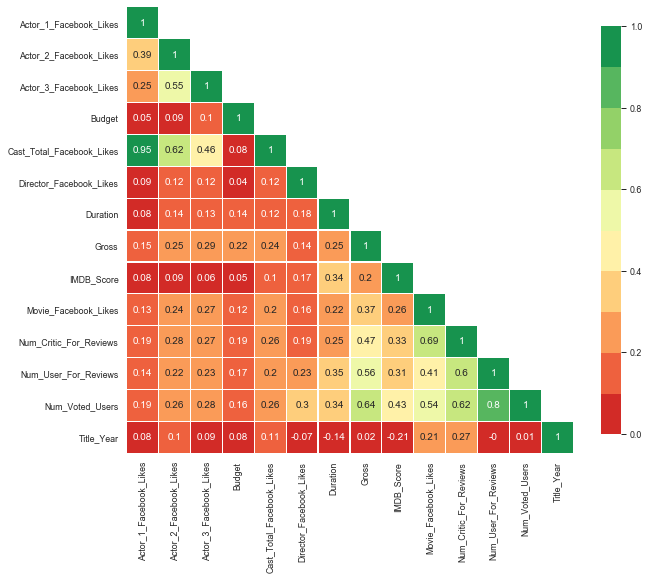

In [38]:
def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr().round(2)
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    Fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("RdYlGn", n_colors=10), linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": .75})
    bottom, top = ax.get_ylim()
    
Correlation_Plot (Data, 10)

In [39]:
Correlation_Matrix = Data.corr()
gross_most_corr_list=list(Correlation_Matrix.Gross[Correlation_Matrix.Gross > 0.5].index)
gross_most_corr_list.remove('Gross')
gross_most_corr_list

['Num_User_For_Reviews', 'Num_Voted_Users']

In [40]:
gross_null = Data[Data['Gross' ].isnull()]
display(gross_null[['Movie_Title', 'Gross']])

,Movie_Title,Gross
84,The Lovers,NaN
98,Godzilla Resurgence,NaN
242,Asterix at the Olympic Games,NaN
367,Ben-Hur,NaN
422,All That Jazz,NaN
...,...,...
5031,Sanctuary; Quite a Conundrum,NaN
5032,Bang,NaN
5036,The Mongol King,NaN
5038,Signed Sealed Delivered,NaN


and

In [41]:
gross_no_null = Data[~Data['Gross' ].isnull()]
display(gross_no_null[['Movie_Title', 'Gross']])

,Movie_Title,Gross
0,Avatar,760505847.0
1,Pirates of the Caribbean: At World's End,309404152.0
2,Spectre,200074175.0
3,The Dark Knight Rises,448130642.0
5,John Carter,73058679.0
...,...,...
5034,Cavite,70071.0
5035,El Mariachi,2040920.0
5037,Newlyweds,4584.0
5041,Shanghai Calling,10443.0


In [42]:
print('It can be seen that %i entries of the gross column has NaN value.' % len(gross_null))

It can be seen that 749 entries of the gross column has NaN value.


Let's do a further test.

In [43]:
X = gross_no_null.loc[:, gross_most_corr_list]
y = gross_no_null.Gross

# Resampling Methods
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
# Linear Regression
reg = LinearRegression()
reg.fit(X_train, y_train)
# prediction
y_pred = reg.predict(X_test)
error = mean_absolute_error(y_test, y_pred)
print("Variance : " + str(round(r2_score(y_test, y_pred), 3)))

Variance : 0.422


Using the predicated values for gross instead of *Nan* values.

In [44]:
Data.loc[Data.Gross.isna(), 'Gross'] = reg.predict(Data.loc[Data.Gross.isna(), gross_most_corr_list])

In [45]:
Data_info(Data)

,Data Type,Number of NaN Values,Size,Percentage
Actor_1_Facebook_Likes,float64,0,4799,0.00
Actor_1_Name,object,0,4799,0.00
Actor_2_Facebook_Likes,float64,0,4799,0.00
Actor_2_Name,object,0,4799,0.00
Actor_3_Facebook_Likes,float64,0,4799,0.00
Actor_3_Name,object,0,4799,0.00
Budget,float64,0,4799,0.00
Cast_Total_Facebook_Likes,int64,0,4799,0.00
Color,object,0,4799,0.00
Content_Rating,object,248,4799,5.17


#### Saving CSV file

In [46]:
# Save as CSV
Data.to_csv('movie_metadata/clean_movie_metadata.csv', index=False)